<h1>Recommadation System

<h3>Import the package required

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy
import pylab
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import spatial
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5

<h2>Data Cleansing

<h4>Check the mails in training_info and training_set are bijiection

In [6]:
def check_info_set(info_filename,set_filename):
    training_info = pd.read_csv(info_filename, sep=',', header=0)
    training = pd.read_csv(set_filename, sep=',', header=0)

    mailIds2 = []
    for mails in training['mids'].tolist():
        mails = mails.split(' ')
        mailIds2.append(mails)
    print "%d senders,correct!"%len(mailIds2) if len(mailIds2)==125 else "Sender(s) missing"

    mailIds2 = [int(mail) for sublist in mailIds2 for mail in sublist]

    print "There are %d mails in training_set"%len(mailIds2)

    print "There are %d mails in training_info"%len(training_info['mid'].tolist())

    print "Checked, they are in Bijection" if set(mailIds2)==set(training_info['mid'].tolist()) else "Not the same"

In [7]:
info_filename = '../data/training_info.csv'
set_filename = '../data/training_set.csv'
check_info_set(info_filename, set_filename)

125 senders,correct!
There are 43613 mails in training_set
There are 43613 mails in training_info
Checked, they are in Bijection


<h4>Merge the training_info and training_set into one file named merged_train

In [8]:
training = pd.read_csv(set_filename, sep=',', header=0)
list_sender = []
list_mid = []

for index,serie in training.iterrows():
    row = serie.tolist()
    sender = row[0]
    ids = row[1].split(" ")
    ids = [int(x) for x in ids]
    for mid in ids:
        list_sender.append(sender)
        list_mid.append(mid)

merged_train = pd.DataFrame({"sender":list_sender, "mid":list_mid})

training_info = pd.read_csv(info_filename, sep=',', header=0)

merged_train = pd.merge(merged_train,training_info)
merged_train = merged_train.sort_values(by='date',ascending=True)

merged_train.mid = merged_train.mid.astype(int)






merged_train.to_csv('../data/merged_data/merged_train.csv',index=False)

<h4>Observe the distribution of mails

In [9]:
def count_by_date(training_info_filename):
    training_info = pd.read_csv(training_info_filename, sep=',', header=0)
    training_info.date = training_info.date.astype("datetime64[ns]")
    training_info['date'].groupby([training_info.date.dt.year,training_info.date.dt.month]).count().plot.bar()
    plt.show()

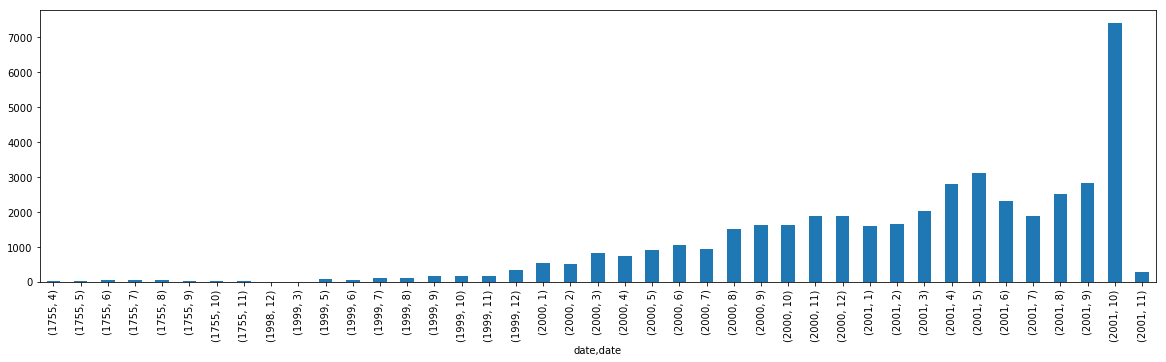

In [20]:
merged_filename = '../data/merged_data/merged_train.csv'
count_by_date(merged_filename)

<h4>Found there are some mails which have weird date

In [21]:
day = numpy.datetime64('1998-01-01').astype("datetime64[ns]")
weird_date = merged_train[merged_train.date.astype("datetime64[ns]") < day]['date'].tolist()
weird_date = [numpy.datetime64(x).astype("datetime64[Y]") for x in weird_date]
print Counter(weird_date)

Counter({numpy.datetime64('0001'): 160, numpy.datetime64('0002'): 42})


<h4>Try to remove them

In [22]:
merged_train = merged_train[merged_train.date.astype("datetime64[ns]") > day]
merged_train.to_csv('../data/merged_train.csv', index=False)

<h4>Logically the number of mails should be 43613 - 160 - 42 = 43411

In [23]:
print len(merged_train.mid.tolist())

43411


<h4>Re-check the distribution of mails

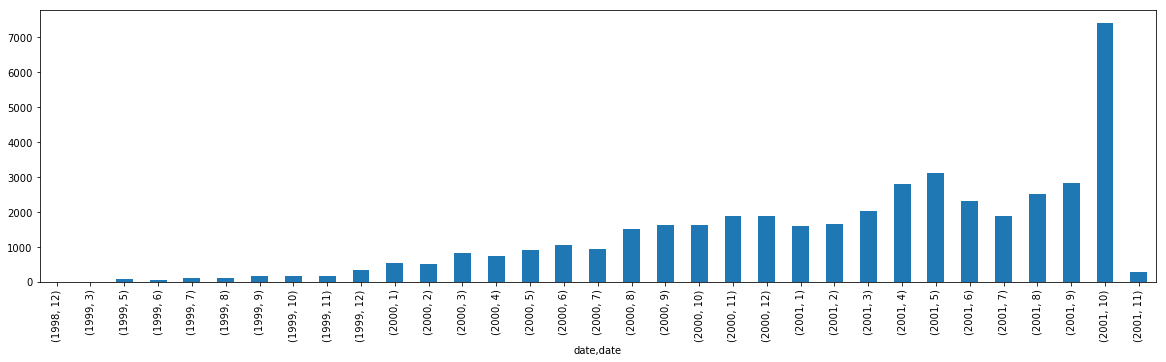

In [24]:
merged_filename = '../data/merged_train.csv'
count_by_date(merged_filename)

<h4>Remove the recipients without "@"

In [28]:
for index,serie in merged_train.iterrows():
    row = serie.tolist()
    recipients = row[4].split(" ")
    recipients = [x for x in recipients if '@' in x]
    recipients = " ".join(recipients)
    merged_train.set_value(index,'recipients',recipients)
    
merged_train.to_csv('../data/merged_data/merged_train.csv',index=False)

<h4>Check the numbers of recipients

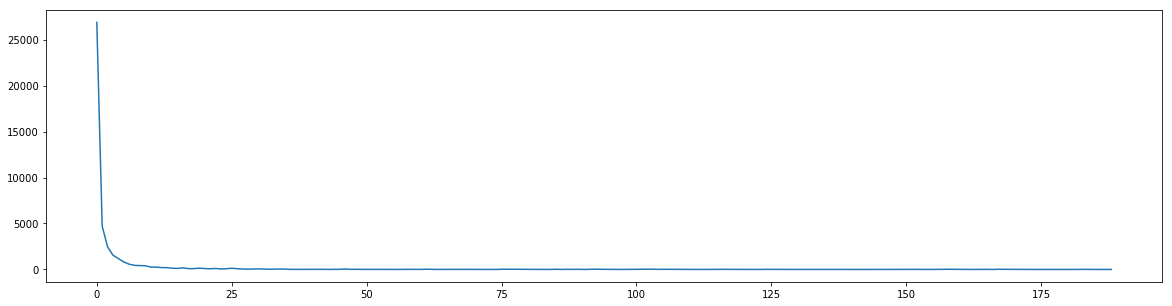

In [29]:
num_rec = []
for recs in merged_train.recipients:
    num_rec.append(len(recs.split(' ')))
    
labels, values = zip(*Counter(num_rec).items())
indexes = numpy.arange(len(labels))
plt.plot(indexes, values)
plt.show()

<h4>Remove the mails noisy -- remove those mails who has more than 25 recipients

In [30]:
to_retain = []
for index,serie in merged_train.iterrows():
    row = serie.tolist()
    mid = row[0]
    recipients = row[4]
    if 0< len(recipients.split(" ")) <=25:
        to_retain.append(mid)
        
merged_train = merged_train[merged_train.mid.isin(to_retain)]
merged_train.to_csv('../data/merged_data/merged_train.csv',index=False)

<h4>Recheck the number of recipients

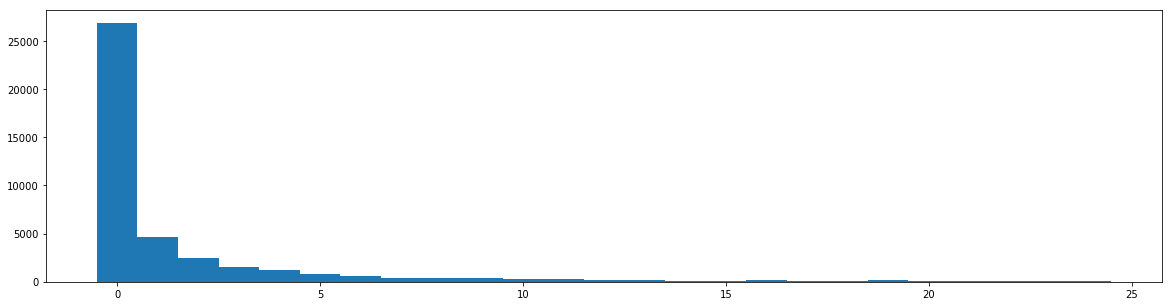

In [36]:
num_rec = []
for recs in merged_train.recipients:
    num_rec.append(len(recs.split(' ')))

    
    


# plt.bar(indexes, values, width)
# plt.xticks(indexes + width * 0.5, labels)
# plt.show()
labels, values = zip(*Counter(num_rec).items())
indexes = numpy.arange(len(labels))
plt.bar(indexes, values,1)
plt.show()

<h3>Merge the test_info and test_set into one file named merged_test

In [37]:
info_filename = '../data/test_info.csv'
set_filename = '../data/test_set.csv'
check_info_set(info_filename, set_filename)

125 senders,correct!
There are 2362 mails in training_set
There are 2362 mails in training_info
Checked, they are in Bijection


In [38]:
test_set_filename = '../data/test_set.csv'
test = pd.read_csv(test_set_filename, sep=',', header=0)

list_sender = []
list_mid = []

for index,serie in test.iterrows():
    row = serie.tolist()
    sender = row[0]
    ids = row[1].split(" ")
    ids = [int(x) for x in ids]
    for mid in ids:
        list_sender.append(sender)
        list_mid.append(int(mid))

merged_test = pd.DataFrame({"sender":list_sender, "mid":list_mid})

test_info_filename = '../data/test_info.csv'
test_info = pd.read_csv(test_info_filename, sep=',', header=0)

merged_test = pd.merge(merged_test,test_info)
merged_test = merged_test.sort_values(by='date',ascending=True)
merged_train.mid = merged_train.mid.astype(int)
merged_test.to_csv('../data/merged_data/merged_test.csv',index=False)

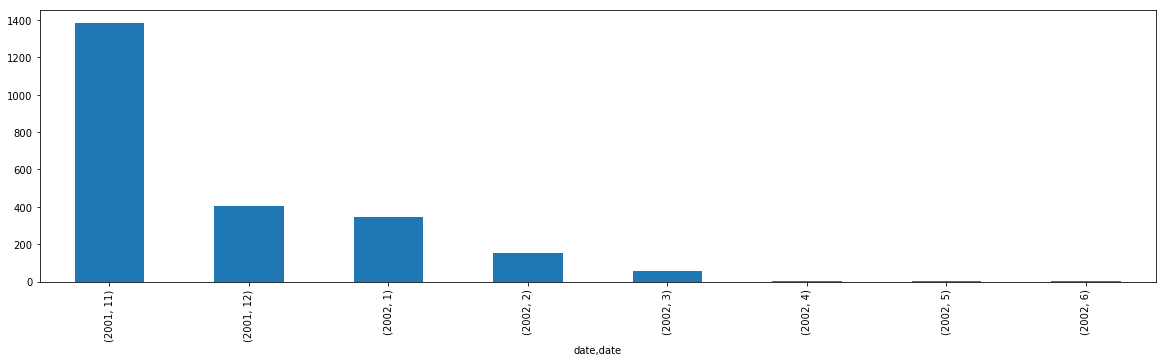

In [40]:
merged_test = '../data/merged_data/merged_test.csv'
count_by_date(merged_test)